# Importing packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import tensorflow as tf

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler

In [2]:
import warnings  # Ignore alert messages
warnings.filterwarnings('ignore')


In [3]:
from utils.preprocessing import *
from utils.fourier import *
from utils.plotting import *
from utils.model_performance import *
from utils.optuna_deep_learning import *

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


# Importing reduced dataset with engineered features

In [6]:
path = './datasets/railway_geometry_data'
file_names = get_file_names(folder_path=path, returns=False)

File names:  ['AE_CNN_1D', 'AE_CNN_1D_plot.png', 'AE_Encoder_1D', 'file1.csv', 'FRA4_vertical_track_irregularities.zip', 'models', 'Vanilla_AE', 'Vanilla_AE_plot.png']
Number of files:  8


In [7]:
df = import_datasets([file_names[3]], import_file_name=False)
df

Unnamed: 0  params.accelRMS.x  params.accelRMS.y  params.accelRMS.z  \
0               0          -0.718541          -0.705534          -0.706060   
1               1          -0.710028          -0.848757          -0.705365   
2               2          -0.695088          -0.946885          -0.699758   
3               3          -0.672540          -0.976557          -0.687735   
4               4          -0.646843          -0.947574          -0.672255   
...           ...                ...                ...                ...   
33896       33896          -0.096945           0.204055           0.328620   
33897       33897          -0.160338           0.097776           0.192101   
33898       33898          -0.240589          -0.036195           0.011078   
33899       33899          -0.333949          -0.191973          -0.204353   
33900       33900          -0.435246          -0.361194          -0.440652   

       params.velRMS.x  params.velRMS.y  params.velRMS.z  \
0            -0.859367        -0.854061        -1.026997   
1            -0.874470        -0.896030        -1.009685   
2            -0.859874        -0.906572        -0.961349   
3            -0.803266        -0.870563        -0.873722   
4            -0.714921        -0.795497        -0.768505   
...                ...              ...              ...   
33896        -0.256080        -0.173035         0.220945   
33897        -0.312894        -0.220065         0.110313   
33898        -0.383763        -0.280380        -0.030543   
33899        -0.465566        -0.351160        -0.194849   
33900        -0.553959        -0.428438        -0.373333   

                                                    name  
0      Ventilador Acima do Elemento GA160 FF - Prédio...  
1      Ventilador Acima do Elemento GA160 FF - Prédio...  
2      Ventilador Acima do Elemento GA160 FF - Prédio...  
3      Ventilador Acima do Elemento GA160 FF - Prédio...  
4      Ventilador Acima do Elemento GA160 FF - Prédio...  
...                                                  ...  
33896                                  ROTULADORA SIDEL   
33897                                  ROTULADORA SIDEL   
33898                                  ROTULADORA SIDEL   
33899                                  ROTULADORA SIDEL   
33900                                  ROTULADORA SIDEL   

[33901 rows x 8 columns]

In [8]:
df_aux2 = df.copy()
name_list = df_aux2['name'].unique()
df_aux2 = df_aux2.loc[(df_aux2['name'] == name_list[0])]
df_aux2.drop(['Unnamed: 0', 'name'], axis=1, inplace=True)
df_aux2

params.accelRMS.x  params.accelRMS.y  params.accelRMS.z  \
0             -0.718541          -0.705534          -0.706060   
1             -0.710028          -0.848757          -0.705365   
2             -0.695088          -0.946885          -0.699758   
3             -0.672540          -0.976557          -0.687735   
4             -0.646843          -0.947574          -0.672255   
...                 ...                ...                ...   
3981          -0.556888          -0.613633          -0.673296   
3982          -0.545120          -0.653843          -0.649928   
3983          -0.580007          -0.709682          -0.645012   
3984          -0.669677          -0.759330          -0.664880   
3985          -0.797581          -0.799472          -0.702371   

      params.velRMS.x  params.velRMS.y  params.velRMS.z  
0           -0.859367        -0.854061        -1.026997  
1           -0.874470        -0.896030        -1.009685  
2           -0.859874        -0.906572        -0.961349  
3           -0.803266        -0.870563        -0.873722  
4           -0.714921        -0.795497        -0.768505  
...               ...              ...              ...  
3981        -0.624571        -0.473524        -0.790710  
3982        -0.588174        -0.476778        -0.691227  
3983        -0.676341        -0.549426        -0.629589  
3984        -0.954184        -0.709925        -0.643210  
3985        -1.380193        -0.934744        -0.717739  

[3986 rows x 6 columns]

# Baseline - PCA

In [9]:
from utils.dim_reduction.dim_reduction import *

In [10]:
optht_pca = PCA(df_aux2.values, strategy='oht')

In [11]:
optht_pca.plot_cumulative_energy()

In [12]:
optht_pca.plot_singular_values(log=False)

In [13]:
optht_pca.plot_3d()

##  Visualizing reconstruction error

In [14]:
arbitrary_cut = 4 # observed in the graph

df_arbitrary = PCA(df_aux2.values, strategy='arbitrary cut',n_components=arbitrary_cut).get_cut_dataset()
df_oht = optht_pca.get_cut_dataset()

print(f'X_arbitrary shape: {df_arbitrary.shape}')
print(f'X_oht shape: {df_oht.shape}')

X_arbitrary shape: (3986, 4)
X_oht shape: (3986, 1)


# Preprocessing

The dataset needs to be preprocessed in order to be used as the input to a 1D CNN neural network

In [15]:
def make_timeseries_instances(timeseries, window_size):
  """Make input features and prediction targets from a `timeseries` for use in machine learning.

  Args:
      timeseries (_type_): Either a simple vector, or a matrix of shape "(timestep, series_num)", i.e., time is axis 0 (the row) and the series is axis 1 (the column).
      window_size (_type_): The number of samples to use as input prediction features (also called the lag or lookback)

  Returns:
      tuple of "(X,Y,q)":  "X" are the inputs to a predictor, a 3D ndarray with shape "(timeseries.shape[0] - window_size, window_size, timeseries.shape[1] or 1)"
                            For each row of "X", the corresponding row of "y" is the next value in the timeseries.  The "q" or query is the last instance, what you would use
                            to predict a hypothetical next (unprovided) value in the "timeseries".
  """

  timeseries = np.asarray(timeseries)
    
  assert 0 < window_size < timeseries.shape[0]
  X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size, window_size)]))
  y = timeseries[window_size:]
  q = np.atleast_3d([timeseries[-window_size:]])
  return X, y, q


In [16]:
df,_,_ = make_timeseries_instances(df_aux2,window_size=40)

In [17]:
print(df.shape)
#print(y.shape)
#print(q.shape)

(99, 40, 6)


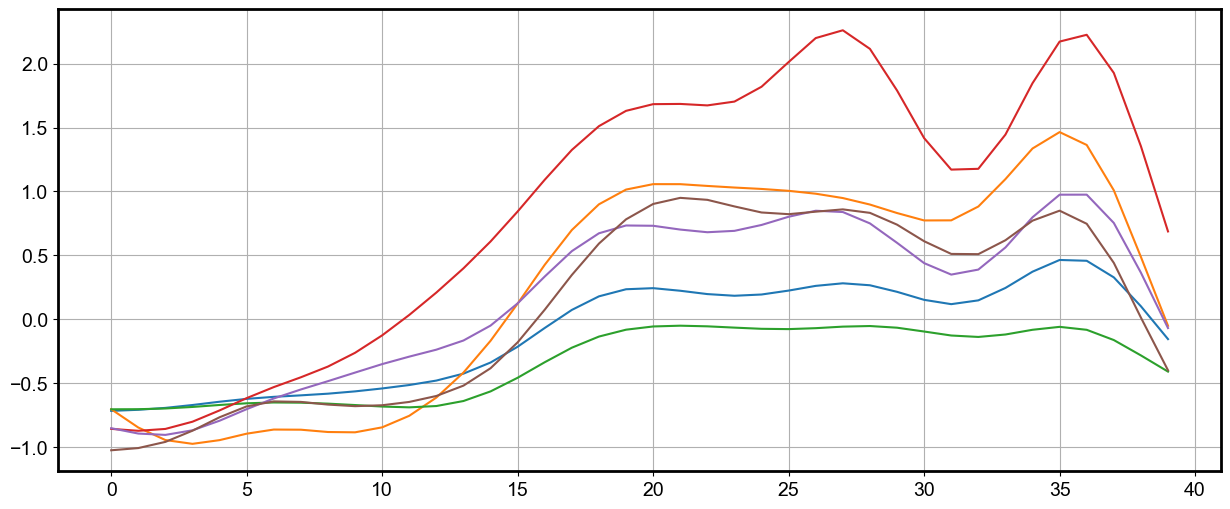

In [18]:
plt.plot(df[0])

# 1D CNN autoencoder

1D convolution explained: https://www.youtube.com/watch?v=yd_j_zdLDWs&ab_channel=Cogneethi

Example 1D autoencoder: https://www.kaggle.com/code/patrick0302/timeseries-fdd-using-an-autoencoder-meters/notebook

In [19]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Reshape, Flatten, Conv1DTranspose, Concatenate, MaxPooling1D, BatchNormalization, UpSampling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow.keras.backend as K

In [20]:
def plot_learning_curve(model):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

    ax.plot(model.history['loss'], label='Train Loss')
    ax.plot(model.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE Loss')
    ax.legend()
    plt.show()

## Testing

In [21]:
# tf.keras.backend.clear_session()
     
# input_data = Input(shape=df.shape[1:3], name='enc_input')
    
# ## Encoder
# x = Conv1D(16, kernel_size=3, activation='relu', padding='same', name='enc_layer1')(input_data)
# x = MaxPooling1D(2, padding='same')(x)
# x = Conv1D(16, kernel_size=3, activation='relu', padding='same',name='enc_layer3')(x)
    
# shape_before_flattening = K.int_shape(x)
# x = Flatten()(x)
# shape_after_flattening = K.int_shape(x)
    
# latent_space = Dense(2,activation='linear',name='latent_space')(x)
    
# encoder = Model(input_data, latent_space)
    
# encoder.summary()

In [22]:
# ## Decoder
    
# decoder_input = Input((2,), name='dec_input')
    
# x = Dense(shape_after_flattening[1], activation='relu', name='dec_dense')(decoder_input)  # Same dimension as after flattening
# x = Reshape(shape_before_flattening[1:3])(x) # Same dimension before flattening
    
# x = Conv1DTranspose(16, kernel_size=3, activation='relu', padding='same',name='dec_layer1')(x)
# x = UpSampling1D(2)(x)
# x = Conv1DTranspose(16, kernel_size=3, activation='relu', padding='same',name='dec_layer2')(x)
# decoded = Conv1DTranspose(df.shape[2], kernel_size=3, activation='relu', padding='same', name='output')(x)
    
# decoder = Model(decoder_input,decoded)
# decoder.summary()

In [23]:
# output = decoder(latent_space)

# ae_1DCNN = Model(input_data, output)

# opt = Adam(learning_rate=0.001)
# ae_1DCNN.compile(optimizer='adam', loss='mse')

# ae_1DCNN.summary()

In [24]:
# trained_autoencoder = ae_1DCNN.fit(df, df, epochs=100,
#                                       batch_size=16,
#                                       shuffle=True,
#                                       validation_split=0.1,
#                                       verbose=1)

In [25]:
# plot_learning_curve(trained_autoencoder)

# Optuna

In [26]:
df_aux2

params.accelRMS.x  params.accelRMS.y  params.accelRMS.z  \
0             -0.718541          -0.705534          -0.706060   
1             -0.710028          -0.848757          -0.705365   
2             -0.695088          -0.946885          -0.699758   
3             -0.672540          -0.976557          -0.687735   
4             -0.646843          -0.947574          -0.672255   
...                 ...                ...                ...   
3981          -0.556888          -0.613633          -0.673296   
3982          -0.545120          -0.653843          -0.649928   
3983          -0.580007          -0.709682          -0.645012   
3984          -0.669677          -0.759330          -0.664880   
3985          -0.797581          -0.799472          -0.702371   

      params.velRMS.x  params.velRMS.y  params.velRMS.z  
0           -0.859367        -0.854061        -1.026997  
1           -0.874470        -0.896030        -1.009685  
2           -0.859874        -0.906572        -0.961349  
3           -0.803266        -0.870563        -0.873722  
4           -0.714921        -0.795497        -0.768505  
...               ...              ...              ...  
3981        -0.624571        -0.473524        -0.790710  
3982        -0.588174        -0.476778        -0.691227  
3983        -0.676341        -0.549426        -0.629589  
3984        -0.954184        -0.709925        -0.643210  
3985        -1.380193        -0.934744        -0.717739  

[3986 rows x 6 columns]

In [27]:
class optuna_ae_CNN1D:

    def __init__(self, df):
        self.best_model = None
        self._model = None

        self._df = df
        # self.samples = df.shape[0]
        # self.timesteps = df.shape[1]
        # self.features = df.shape[2]

        self.callbacks = None
        self.history = None
        self._history = None

    def create_ae(self, num_layers, latent_dim, trial):
        
        tf.keras.backend.clear_session()
        
        # Define window for the 1D CNN and do the preprocessing/reshaping
        window_size = trial.suggest_int('window_size', 4, 40, step=4)
        self.df, _, _ = make_timeseries_instances(self._df, window_size=window_size)
        
        self.samples = self.df.shape[0]
        self.timesteps = self.df.shape[1]
        self.features = self.df.shape[2]
        
        
        ############################
        # Encoder
        ############################
        
        # 1st layer of the encoder
        input_data = Input(shape=(self.timesteps,self.features),name='enc_input')
        
        filter_L1 = trial.suggest_int('filters_l1', 2, 6, step=1)
        kernel_size_L1 = trial.suggest_int('kernel_size_l1', 2, 6, step=1),
        activation_L1 = trial.suggest_categorical("activation_l1", ["relu", "sigmoid", "swish", "linear"])
        
        x = Conv1D(filters=filter_L1,kernel_size=kernel_size_L1,activation=activation_L1,padding='same',name='enc_l1')(input_data)
        x = MaxPooling1D(2,padding='same')(x)
        
        # Encoder (2nd layer and beyond)
        for i in range(2,num_layers,1):
            
            filters = trial.suggest_int('filters_l{}'.format(i),2, 6, step=1)
            kernel_size = trial.suggest_int('kernel_size_l{}'.format(i), 2, 6, step=1),
            activation = trial.suggest_categorical("activation_l{}".format(i), ["relu", "sigmoid", "swish", "linear"])
            
            x = Conv1D(filters=filters,kernel_size=kernel_size,activation=activation,padding='same',name='enc_l' + str(i))(x)
            x = MaxPooling1D(2,padding='same')(x)
            
            
        # Reshaping the latent space representation so that has "latent_dim" columns while the rest are rows
        shape_before_flattening = K.int_shape(x)
        x = Flatten()(x)
        shape_after_flattening = K.int_shape(x)
        
        latent_space = Dense(latent_dim,activation='linear',name='latent_space')(x)
        encoder = Model(input_data,latent_space)
        
        ############################
        # Decoder
        ############################
        
        decoder_input = Input((latent_dim,), name='dec_input')
        x = Dense(shape_after_flattening[1],activation ='linear',name='dec_dense')(decoder_input)
        x = Reshape(shape_before_flattening[1:3])(x)
        
        for i in reversed(range(2,num_layers,1)):
            
            filters = trial.suggest_int('filters_l{}'.format(i), 2, 6, step=1)
            kernel_size = trial.suggest_int('kernel_size_l{}'.format(i), 2, 6, step=1),
            activation = trial.suggest_categorical("activation_l{}".format(i),["relu", "sigmoid", "swish", "linear"])
            
            x = Conv1DTranspose(filters=filters,kernel_size=kernel_size,activation=activation,padding='same',name='dec_l' + str(i))(x)
            x = UpSampling1D(2)(x)
        
        x = Conv1DTranspose(filters=filter_L1, kernel_size=filter_L1,activation=activation_L1, padding='same', name='dec_l1')(x)
        x = UpSampling1D(2)(x)
        
        # Output layer
        decoded = Conv1DTranspose(self.features,kernel_size=filter_L1,activation='linear',padding='same',name='output')(x)
        
        decoder = Model(decoder_input,decoded)
        ae_1DCNN = Model(input_data, decoder(latent_space))
        
        # self._encoder = encoder
        # self._decoder = decoder
        # self._ae = ae_1DCNN
        
        #print(encoder.summary())
        #print(decoder.summary())
        
        
        return encoder,decoder,ae_1DCNN
        
    # Objective function to be optimized by Optuna
    def objective(self,trial):    
        
        # Optuna objective variables
        num_layers = trial.suggest_int('n_layers', 1,3)
        latent_dim =  2 # trial.suggest_categorical('latent_dim', list(np.arange(2, 16, 1, dtype=int)))
        learning_rate = 1e-2#trial.suggest_loguniform("lr", 1e-3, 1e-1)
        
        # Defining callbacks
        
        MAX_EPOCHS = 200
        PATIENCE = 10  # Number of epochs to check if the error continues to decrease
        INTERVAL = 40  # Intermediate results saved and pruned/removed if it is bad
        BATCH_SIZE = 32
        
        early_stopping = EarlyStopping(monitor='val_loss',patience=PATIENCE,mode='min')
        optuna_pruner = KerasPruningCallback(trial, "val_loss", interval=INTERVAL)
        self.callbacks = [early_stopping, optuna_pruner]
        
        enc, dec, model = self.create_ae(num_layers, latent_dim, trial)

        # Compile and fit the model
        model.compile(loss='mse',optimizer=Adam(learning_rate=learning_rate))
        
        self._history = model.fit(self.df,
                                  self.df,
                                  epochs=MAX_EPOCHS,
                                  validation_split=0.20,
                                  callbacks=self.callbacks,
                                  shuffle=False,
                                  batch_size=BATCH_SIZE,
                                  verbose=0)
        
        self._model = model
        self._encoder = enc
        self._decoder = dec
        
        # Returning objective function
        return self._history.history["val_loss"][-1]

    
    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model
            self.history = self._history
            self.encoder = self._encoder
            self.decoder = self._decoder
            self.df_windowed = self.df

In [28]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.integration import KerasPruningCallback

In [29]:
ae = optuna_ae_CNN1D(df_aux2)

study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(seed=10),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            study_name='1DCNN_AE')

[I 2022-04-07 11:28:43,613] A new study created in memory with name: 1DCNN_AE


In [30]:
study.optimize(ae.objective, 
               n_trials=200,
               callbacks=[ae.callback],
               show_progress_bar=True)

  0%|          | 1/200 [00:14<48:26, 14.61s/it]

[I 2022-04-07 11:28:58,313] Trial 0 finished with value: 0.026617346331477165 and parameters: {'n_layers': 3, 'window_size': 4, 'filters_l1': 5, 'kernel_size_l1': 5, 'activation_l1': 'linear', 'filters_l2': 2, 'kernel_size_l2': 2, 'activation_l2': 'sigmoid'}. Best is trial 0 with value: 0.026617346331477165.


  1%|          | 2/200 [00:19<28:46,  8.72s/it]

[I 2022-04-07 11:29:02,913] Trial 1 finished with value: 0.07909790426492691 and parameters: {'n_layers': 3, 'window_size': 28, 'filters_l1': 5, 'kernel_size_l1': 3, 'activation_l1': 'relu', 'filters_l2': 3, 'kernel_size_l2': 5, 'activation_l2': 'swish'}. Best is trial 0 with value: 0.026617346331477165.


  2%|▏         | 3/200 [00:22<21:02,  6.41s/it]

[I 2022-04-07 11:29:06,571] Trial 2 finished with value: 0.07728015631437302 and parameters: {'n_layers': 2, 'window_size': 28, 'filters_l1': 6, 'kernel_size_l1': 4, 'activation_l1': 'relu'}. Best is trial 0 with value: 0.026617346331477165.


  2%|▏         | 4/200 [00:29<21:10,  6.48s/it]

[I 2022-04-07 11:29:13,159] Trial 3 finished with value: 0.1032453328371048 and parameters: {'n_layers': 1, 'window_size': 36, 'filters_l1': 2, 'kernel_size_l1': 5, 'activation_l1': 'linear'}. Best is trial 0 with value: 0.026617346331477165.


  2%|▎         | 5/200 [00:32<16:43,  5.14s/it]

[I 2022-04-07 11:29:15,935] Trial 4 finished with value: 0.1221286803483963 and parameters: {'n_layers': 2, 'window_size': 32, 'filters_l1': 3, 'kernel_size_l1': 6, 'activation_l1': 'swish'}. Best is trial 0 with value: 0.026617346331477165.


  3%|▎         | 6/200 [00:39<19:05,  5.91s/it]

[I 2022-04-07 11:29:23,323] Trial 5 finished with value: 0.025946086272597313 and parameters: {'n_layers': 3, 'window_size': 8, 'filters_l1': 3, 'kernel_size_l1': 6, 'activation_l1': 'relu', 'filters_l2': 4, 'kernel_size_l2': 6, 'activation_l2': 'sigmoid'}. Best is trial 5 with value: 0.025946086272597313.


  4%|▎         | 7/200 [00:43<16:49,  5.23s/it]

[I 2022-04-07 11:29:27,168] Trial 6 finished with value: 0.05055747553706169 and parameters: {'n_layers': 1, 'window_size': 16, 'filters_l1': 3, 'kernel_size_l1': 5, 'activation_l1': 'linear'}. Best is trial 5 with value: 0.025946086272597313.


  4%|▍         | 8/200 [00:52<20:27,  6.39s/it]

[I 2022-04-07 11:29:36,039] Trial 7 finished with value: 0.013119173236191273 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 5, 'activation_l1': 'relu'}. Best is trial 7 with value: 0.013119173236191273.


  4%|▍         | 9/200 [00:57<19:03,  5.99s/it]

[I 2022-04-07 11:29:41,143] Trial 8 finished with value: 0.03817529231309891 and parameters: {'n_layers': 2, 'window_size': 12, 'filters_l1': 3, 'kernel_size_l1': 2, 'activation_l1': 'linear'}. Best is trial 7 with value: 0.013119173236191273.


  5%|▌         | 10/200 [01:05<20:32,  6.49s/it]

[I 2022-04-07 11:29:48,741] Trial 9 finished with value: 0.039191097021102905 and parameters: {'n_layers': 2, 'window_size': 12, 'filters_l1': 2, 'kernel_size_l1': 6, 'activation_l1': 'swish'}. Best is trial 7 with value: 0.013119173236191273.


  6%|▌         | 11/200 [01:08<17:15,  5.48s/it]

[I 2022-04-07 11:29:51,935] Trial 10 pruned. Trial was pruned at epoch 39.


  6%|▌         | 12/200 [01:21<24:57,  7.97s/it]

[I 2022-04-07 11:30:05,594] Trial 11 finished with value: 0.015120867639780045 and parameters: {'n_layers': 3, 'window_size': 4, 'filters_l1': 4, 'kernel_size_l1': 6, 'activation_l1': 'relu', 'filters_l2': 6, 'kernel_size_l2': 6, 'activation_l2': 'relu'}. Best is trial 7 with value: 0.013119173236191273.


  6%|▋         | 13/200 [01:26<21:15,  6.82s/it]

[I 2022-04-07 11:30:09,778] Trial 12 finished with value: 0.5574623346328735 and parameters: {'n_layers': 3, 'window_size': 4, 'filters_l1': 5, 'kernel_size_l1': 5, 'activation_l1': 'relu', 'filters_l2': 6, 'kernel_size_l2': 3, 'activation_l2': 'relu'}. Best is trial 7 with value: 0.013119173236191273.


  7%|▋         | 14/200 [01:36<24:36,  7.94s/it]

[I 2022-04-07 11:30:20,306] Trial 13 finished with value: 0.013232543133199215 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 4, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 7 with value: 0.013119173236191273.


  8%|▊         | 15/200 [01:40<20:42,  6.72s/it]

[I 2022-04-07 11:30:24,186] Trial 14 pruned. Trial was pruned at epoch 39.


  8%|▊         | 16/200 [01:43<17:33,  5.73s/it]

[I 2022-04-07 11:30:27,618] Trial 15 pruned. Trial was pruned at epoch 39.


  8%|▊         | 17/200 [01:46<14:31,  4.76s/it]

[I 2022-04-07 11:30:30,140] Trial 16 finished with value: 0.16818341612815857 and parameters: {'n_layers': 1, 'window_size': 40, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 7 with value: 0.013119173236191273.


  9%|▉         | 18/200 [01:51<15:09,  5.00s/it]

[I 2022-04-07 11:30:35,684] Trial 17 finished with value: 0.02110714465379715 and parameters: {'n_layers': 2, 'window_size': 8, 'filters_l1': 4, 'kernel_size_l1': 4, 'activation_l1': 'relu'}. Best is trial 7 with value: 0.013119173236191273.


 10%|▉         | 19/200 [01:55<13:35,  4.51s/it]

[I 2022-04-07 11:30:39,042] Trial 18 pruned. Trial was pruned at epoch 39.


 10%|█         | 20/200 [02:01<14:46,  4.92s/it]

[I 2022-04-07 11:30:44,940] Trial 19 finished with value: 0.0257073063403368 and parameters: {'n_layers': 1, 'window_size': 8, 'filters_l1': 5, 'kernel_size_l1': 3, 'activation_l1': 'swish'}. Best is trial 7 with value: 0.013119173236191273.


 10%|█         | 21/200 [02:04<13:04,  4.38s/it]

[I 2022-04-07 11:30:48,060] Trial 20 pruned. Trial was pruned at epoch 39.


 11%|█         | 22/200 [02:10<14:55,  5.03s/it]

[I 2022-04-07 11:30:54,605] Trial 21 finished with value: 0.015109381638467312 and parameters: {'n_layers': 3, 'window_size': 4, 'filters_l1': 4, 'kernel_size_l1': 6, 'activation_l1': 'relu', 'filters_l2': 6, 'kernel_size_l2': 6, 'activation_l2': 'linear'}. Best is trial 7 with value: 0.013119173236191273.


 12%|█▏        | 23/200 [02:22<21:04,  7.14s/it]

[I 2022-04-07 11:31:06,676] Trial 22 finished with value: 0.012902963906526566 and parameters: {'n_layers': 3, 'window_size': 4, 'filters_l1': 4, 'kernel_size_l1': 6, 'activation_l1': 'relu', 'filters_l2': 5, 'kernel_size_l2': 4, 'activation_l2': 'linear'}. Best is trial 22 with value: 0.012902963906526566.


 12%|█▏        | 24/200 [02:29<20:27,  6.97s/it]

[I 2022-04-07 11:31:13,252] Trial 23 finished with value: 0.022653216496109962 and parameters: {'n_layers': 3, 'window_size': 8, 'filters_l1': 4, 'kernel_size_l1': 6, 'activation_l1': 'relu', 'filters_l2': 4, 'kernel_size_l2': 4, 'activation_l2': 'linear'}. Best is trial 22 with value: 0.012902963906526566.


 12%|█▎        | 25/200 [02:44<26:53,  9.22s/it]

[I 2022-04-07 11:31:27,716] Trial 24 finished with value: 0.013571730814874172 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 3, 'kernel_size_l1': 5, 'activation_l1': 'relu'}. Best is trial 22 with value: 0.012902963906526566.


 13%|█▎        | 26/200 [02:52<26:01,  8.98s/it]

[I 2022-04-07 11:31:36,121] Trial 25 pruned. Trial was pruned at epoch 39.


 14%|█▎        | 27/200 [02:59<24:38,  8.54s/it]

[I 2022-04-07 11:31:43,657] Trial 26 pruned. Trial was pruned at epoch 39.


 14%|█▍        | 28/200 [03:07<23:45,  8.29s/it]

[I 2022-04-07 11:31:51,350] Trial 27 pruned. Trial was pruned at epoch 39.


 14%|█▍        | 29/200 [03:29<35:07, 12.33s/it]

[I 2022-04-07 11:32:13,102] Trial 28 finished with value: 0.013532407581806183 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 5, 'kernel_size_l1': 5, 'activation_l1': 'sigmoid'}. Best is trial 22 with value: 0.012902963906526566.


 15%|█▌        | 30/200 [03:37<31:18, 11.05s/it]

[I 2022-04-07 11:32:21,163] Trial 29 finished with value: 0.013832135125994682 and parameters: {'n_layers': 3, 'window_size': 4, 'filters_l1': 5, 'kernel_size_l1': 6, 'activation_l1': 'linear', 'filters_l2': 5, 'kernel_size_l2': 2, 'activation_l2': 'swish'}. Best is trial 22 with value: 0.012902963906526566.


 16%|█▌        | 31/200 [03:42<25:53,  9.20s/it]

[I 2022-04-07 11:32:26,036] Trial 30 pruned. Trial was pruned at epoch 39.


 16%|█▌        | 32/200 [03:56<30:03, 10.74s/it]

[I 2022-04-07 11:32:40,368] Trial 31 finished with value: 0.013797146268188953 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 5, 'kernel_size_l1': 5, 'activation_l1': 'sigmoid'}. Best is trial 22 with value: 0.012902963906526566.


 16%|█▋        | 33/200 [04:15<36:42, 13.19s/it]

[I 2022-04-07 11:32:59,272] Trial 32 finished with value: 0.013232815079391003 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 5, 'activation_l1': 'sigmoid'}. Best is trial 22 with value: 0.012902963906526566.


 17%|█▋        | 34/200 [04:20<29:16, 10.58s/it]

[I 2022-04-07 11:33:03,781] Trial 33 pruned. Trial was pruned at epoch 39.


 18%|█▊        | 35/200 [04:24<23:43,  8.63s/it]

[I 2022-04-07 11:33:07,849] Trial 34 pruned. Trial was pruned at epoch 39.


 18%|█▊        | 36/200 [04:30<22:02,  8.07s/it]

[I 2022-04-07 11:33:14,601] Trial 35 finished with value: 0.013964010402560234 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 4, 'activation_l1': 'relu'}. Best is trial 22 with value: 0.012902963906526566.


 18%|█▊        | 37/200 [04:35<18:52,  6.95s/it]

[I 2022-04-07 11:33:18,938] Trial 36 pruned. Trial was pruned at epoch 39.


 19%|█▉        | 38/200 [04:38<16:02,  5.94s/it]

[I 2022-04-07 11:33:22,542] Trial 37 pruned. Trial was pruned at epoch 39.


 20%|█▉        | 39/200 [04:41<13:42,  5.11s/it]

[I 2022-04-07 11:33:25,698] Trial 38 pruned. Trial was pruned at epoch 39.


 20%|██        | 40/200 [04:45<12:37,  4.73s/it]

[I 2022-04-07 11:33:29,554] Trial 39 pruned. Trial was pruned at epoch 39.


 20%|██        | 41/200 [04:50<12:25,  4.69s/it]

[I 2022-04-07 11:33:34,150] Trial 40 pruned. Trial was pruned at epoch 39.


 21%|██        | 42/200 [05:11<25:11,  9.57s/it]

[I 2022-04-07 11:33:55,095] Trial 41 finished with value: 0.013432030566036701 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 5, 'kernel_size_l1': 5, 'activation_l1': 'sigmoid'}. Best is trial 22 with value: 0.012902963906526566.


 22%|██▏       | 43/200 [05:16<21:47,  8.33s/it]

[I 2022-04-07 11:34:00,534] Trial 42 pruned. Trial was pruned at epoch 39.


 22%|██▏       | 44/200 [05:21<18:31,  7.13s/it]

[I 2022-04-07 11:34:04,850] Trial 43 pruned. Trial was pruned at epoch 39.


 22%|██▎       | 45/200 [05:42<29:13, 11.31s/it]

[I 2022-04-07 11:34:25,928] Trial 44 finished with value: 0.013097774237394333 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'sigmoid'}. Best is trial 22 with value: 0.012902963906526566.


 23%|██▎       | 46/200 [05:46<23:43,  9.24s/it]

[I 2022-04-07 11:34:30,337] Trial 45 finished with value: 0.014166634529829025 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'linear'}. Best is trial 22 with value: 0.012902963906526566.


 24%|██▎       | 47/200 [05:50<19:17,  7.56s/it]

[I 2022-04-07 11:34:33,988] Trial 46 pruned. Trial was pruned at epoch 39.


 24%|██▍       | 48/200 [05:54<16:31,  6.52s/it]

[I 2022-04-07 11:34:38,077] Trial 47 pruned. Trial was pruned at epoch 39.


 24%|██▍       | 49/200 [05:59<15:39,  6.22s/it]

[I 2022-04-07 11:34:43,609] Trial 48 pruned. Trial was pruned at epoch 39.


 25%|██▌       | 50/200 [06:02<12:53,  5.16s/it]

[I 2022-04-07 11:34:46,269] Trial 49 finished with value: 0.12400275468826294 and parameters: {'n_layers': 1, 'window_size': 32, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'swish'}. Best is trial 22 with value: 0.012902963906526566.


 26%|██▌       | 51/200 [06:06<11:57,  4.82s/it]

[I 2022-04-07 11:34:50,296] Trial 50 finished with value: 0.022509662434458733 and parameters: {'n_layers': 2, 'window_size': 8, 'filters_l1': 4, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 22 with value: 0.012902963906526566.


 26%|██▌       | 52/200 [06:13<13:08,  5.32s/it]

[I 2022-04-07 11:34:56,808] Trial 51 pruned. Trial was pruned at epoch 39.


 26%|██▋       | 53/200 [06:29<21:03,  8.60s/it]

[I 2022-04-07 11:35:13,040] Trial 52 finished with value: 0.013214942999184132 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 5, 'activation_l1': 'sigmoid'}. Best is trial 22 with value: 0.012902963906526566.


 27%|██▋       | 54/200 [06:44<25:50, 10.62s/it]

[I 2022-04-07 11:35:28,385] Trial 53 pruned. Trial was pruned at epoch 119.


 28%|██▊       | 55/200 [06:51<23:09,  9.58s/it]

[I 2022-04-07 11:35:35,538] Trial 54 pruned. Trial was pruned at epoch 39.


 28%|██▊       | 56/200 [06:59<21:51,  9.11s/it]

[I 2022-04-07 11:35:43,552] Trial 55 finished with value: 0.013005890883505344 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 22 with value: 0.012902963906526566.


 28%|██▊       | 57/200 [07:02<17:24,  7.31s/it]

[I 2022-04-07 11:35:46,649] Trial 56 pruned. Trial was pruned at epoch 39.


 29%|██▉       | 58/200 [07:06<14:52,  6.28s/it]

[I 2022-04-07 11:35:50,551] Trial 57 pruned. Trial was pruned at epoch 39.


 30%|██▉       | 59/200 [07:10<13:14,  5.64s/it]

[I 2022-04-07 11:35:54,677] Trial 58 finished with value: 0.12366701662540436 and parameters: {'n_layers': 3, 'window_size': 40, 'filters_l1': 4, 'kernel_size_l1': 6, 'activation_l1': 'relu', 'filters_l2': 2, 'kernel_size_l2': 3, 'activation_l2': 'sigmoid'}. Best is trial 22 with value: 0.012902963906526566.


 30%|███       | 60/200 [07:15<12:04,  5.18s/it]

[I 2022-04-07 11:35:58,774] Trial 59 pruned. Trial was pruned at epoch 39.


 30%|███       | 61/200 [07:18<10:54,  4.71s/it]

[I 2022-04-07 11:36:02,385] Trial 60 pruned. Trial was pruned at epoch 39.


 31%|███       | 62/200 [07:44<25:23, 11.04s/it]

[I 2022-04-07 11:36:28,199] Trial 61 finished with value: 0.013040021993219852 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 5, 'activation_l1': 'sigmoid'}. Best is trial 22 with value: 0.012902963906526566.


 32%|███▏      | 63/200 [07:49<20:45,  9.09s/it]

[I 2022-04-07 11:36:32,752] Trial 62 finished with value: 0.014074606820940971 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 5, 'activation_l1': 'relu'}. Best is trial 22 with value: 0.012902963906526566.


 32%|███▏      | 64/200 [07:55<18:52,  8.32s/it]

[I 2022-04-07 11:36:39,282] Trial 63 finished with value: 0.01372013334184885 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'linear'}. Best is trial 22 with value: 0.012902963906526566.


 32%|███▎      | 65/200 [07:59<15:56,  7.09s/it]

[I 2022-04-07 11:36:43,483] Trial 64 pruned. Trial was pruned at epoch 39.


 33%|███▎      | 66/200 [08:16<22:22, 10.02s/it]

[I 2022-04-07 11:37:00,353] Trial 65 finished with value: 0.013630288653075695 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'sigmoid'}. Best is trial 22 with value: 0.012902963906526566.


 34%|███▎      | 67/200 [08:25<21:17,  9.60s/it]

[I 2022-04-07 11:37:08,972] Trial 66 finished with value: 0.013381599448621273 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 4, 'kernel_size_l1': 5, 'activation_l1': 'swish'}. Best is trial 22 with value: 0.012902963906526566.


 34%|███▍      | 68/200 [08:29<17:45,  8.07s/it]

[I 2022-04-07 11:37:13,469] Trial 67 pruned. Trial was pruned at epoch 39.


 34%|███▍      | 69/200 [08:35<16:22,  7.50s/it]

[I 2022-04-07 11:37:19,646] Trial 68 pruned. Trial was pruned at epoch 39.


 35%|███▌      | 70/200 [08:40<14:32,  6.71s/it]

[I 2022-04-07 11:37:24,504] Trial 69 pruned. Trial was pruned at epoch 39.


 36%|███▌      | 71/200 [08:47<14:31,  6.76s/it]

[I 2022-04-07 11:37:31,370] Trial 70 pruned. Trial was pruned at epoch 39.


 36%|███▌      | 72/200 [08:53<14:06,  6.61s/it]

[I 2022-04-07 11:37:37,649] Trial 71 pruned. Trial was pruned at epoch 39.


 36%|███▋      | 73/200 [08:59<13:36,  6.43s/it]

[I 2022-04-07 11:37:43,643] Trial 72 pruned. Trial was pruned at epoch 39.


 37%|███▋      | 74/200 [09:21<23:01, 10.97s/it]

[I 2022-04-07 11:38:05,201] Trial 73 finished with value: 0.01289916317909956 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 4, 'activation_l1': 'sigmoid'}. Best is trial 73 with value: 0.01289916317909956.


 38%|███▊      | 75/200 [09:27<19:54,  9.55s/it]

[I 2022-04-07 11:38:11,461] Trial 74 pruned. Trial was pruned at epoch 39.


 38%|███▊      | 76/200 [09:31<16:23,  7.93s/it]

[I 2022-04-07 11:38:15,611] Trial 75 pruned. Trial was pruned at epoch 39.


 38%|███▊      | 77/200 [09:45<19:28,  9.50s/it]

[I 2022-04-07 11:38:28,754] Trial 76 finished with value: 0.013385233469307423 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 4, 'activation_l1': 'sigmoid'}. Best is trial 73 with value: 0.01289916317909956.


 39%|███▉      | 78/200 [09:50<16:37,  8.18s/it]

[I 2022-04-07 11:38:33,857] Trial 77 pruned. Trial was pruned at epoch 39.


 40%|███▉      | 79/200 [09:54<14:07,  7.01s/it]

[I 2022-04-07 11:38:38,132] Trial 78 pruned. Trial was pruned at epoch 39.


 40%|████      | 80/200 [09:57<11:48,  5.91s/it]

[I 2022-04-07 11:38:41,468] Trial 79 pruned. Trial was pruned at epoch 39.


 40%|████      | 81/200 [10:06<13:14,  6.68s/it]

[I 2022-04-07 11:38:49,938] Trial 80 finished with value: 0.01422131061553955 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 3, 'kernel_size_l1': 3, 'activation_l1': 'swish'}. Best is trial 73 with value: 0.01289916317909956.


 41%|████      | 82/200 [10:12<12:53,  6.56s/it]

[I 2022-04-07 11:38:56,215] Trial 81 pruned. Trial was pruned at epoch 39.


 42%|████▏     | 83/200 [10:18<12:31,  6.42s/it]

[I 2022-04-07 11:39:02,321] Trial 82 pruned. Trial was pruned at epoch 39.


 42%|████▏     | 84/200 [10:24<12:04,  6.25s/it]

[I 2022-04-07 11:39:08,170] Trial 83 pruned. Trial was pruned at epoch 39.


 42%|████▎     | 85/200 [10:28<10:57,  5.71s/it]

[I 2022-04-07 11:39:12,634] Trial 84 pruned. Trial was pruned at epoch 39.


 43%|████▎     | 86/200 [10:43<16:03,  8.45s/it]

[I 2022-04-07 11:39:27,476] Trial 85 finished with value: 0.013275686651468277 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'sigmoid'}. Best is trial 73 with value: 0.01289916317909956.


 44%|████▎     | 87/200 [10:50<15:05,  8.01s/it]

[I 2022-04-07 11:39:34,467] Trial 86 finished with value: 0.014293965883553028 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 4, 'kernel_size_l1': 5, 'activation_l1': 'relu'}. Best is trial 73 with value: 0.01289916317909956.


 44%|████▍     | 88/200 [10:54<12:46,  6.84s/it]

[I 2022-04-07 11:39:38,577] Trial 87 pruned. Trial was pruned at epoch 39.


 44%|████▍     | 89/200 [11:03<13:22,  7.23s/it]

[I 2022-04-07 11:39:46,719] Trial 88 finished with value: 0.013553724624216557 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 5, 'kernel_size_l1': 2, 'activation_l1': 'relu'}. Best is trial 73 with value: 0.01289916317909956.


 45%|████▌     | 90/200 [11:09<12:44,  6.95s/it]

[I 2022-04-07 11:39:53,013] Trial 89 pruned. Trial was pruned at epoch 39.


 46%|████▌     | 91/200 [11:17<13:15,  7.30s/it]

[I 2022-04-07 11:40:01,114] Trial 90 finished with value: 0.01324805524200201 and parameters: {'n_layers': 1, 'window_size': 4, 'filters_l1': 4, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 73 with value: 0.01289916317909956.


 46%|████▌     | 92/200 [11:24<13:04,  7.27s/it]

[I 2022-04-07 11:40:08,309] Trial 91 finished with value: 0.01379958726465702 and parameters: {'n_layers': 1, 'window_size': 4, 'filters_l1': 4, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 73 with value: 0.01289916317909956.


 46%|████▋     | 93/200 [11:32<13:12,  7.41s/it]

[I 2022-04-07 11:40:16,045] Trial 92 pruned. Trial was pruned at epoch 39.


 47%|████▋     | 94/200 [11:43<15:05,  8.54s/it]

[I 2022-04-07 11:40:27,229] Trial 93 finished with value: 0.013301858678460121 and parameters: {'n_layers': 1, 'window_size': 4, 'filters_l1': 4, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 73 with value: 0.01289916317909956.


 48%|████▊     | 95/200 [11:49<13:50,  7.91s/it]

[I 2022-04-07 11:40:33,666] Trial 94 finished with value: 0.013382765464484692 and parameters: {'n_layers': 1, 'window_size': 4, 'filters_l1': 4, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 73 with value: 0.01289916317909956.


 48%|████▊     | 96/200 [11:58<13:51,  7.99s/it]

[I 2022-04-07 11:40:41,853] Trial 95 pruned. Trial was pruned at epoch 39.


 48%|████▊     | 97/200 [12:01<11:23,  6.63s/it]

[I 2022-04-07 11:40:45,311] Trial 96 finished with value: 0.021508164703845978 and parameters: {'n_layers': 1, 'window_size': 8, 'filters_l1': 6, 'kernel_size_l1': 4, 'activation_l1': 'linear'}. Best is trial 73 with value: 0.01289916317909956.


 49%|████▉     | 98/200 [12:11<12:54,  7.59s/it]

[I 2022-04-07 11:40:55,152] Trial 97 pruned. Trial was pruned at epoch 39.


 50%|████▉     | 99/200 [12:17<11:54,  7.08s/it]

[I 2022-04-07 11:41:01,026] Trial 98 pruned. Trial was pruned at epoch 39.


 50%|█████     | 100/200 [12:21<10:34,  6.35s/it]

[I 2022-04-07 11:41:05,661] Trial 99 pruned. Trial was pruned at epoch 39.


 50%|█████     | 101/200 [12:28<10:31,  6.38s/it]

[I 2022-04-07 11:41:12,108] Trial 100 pruned. Trial was pruned at epoch 39.


 51%|█████     | 102/200 [12:34<10:29,  6.43s/it]

[I 2022-04-07 11:41:18,654] Trial 101 pruned. Trial was pruned at epoch 39.


 52%|█████▏    | 103/200 [12:41<10:31,  6.51s/it]

[I 2022-04-07 11:41:25,357] Trial 102 pruned. Trial was pruned at epoch 39.


 52%|█████▏    | 104/200 [12:48<10:26,  6.52s/it]

[I 2022-04-07 11:41:31,910] Trial 103 pruned. Trial was pruned at epoch 39.


 52%|█████▎    | 105/200 [12:58<12:06,  7.65s/it]

[I 2022-04-07 11:41:42,187] Trial 104 finished with value: 0.013877997174859047 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'sigmoid'}. Best is trial 73 with value: 0.01289916317909956.


 53%|█████▎    | 106/200 [13:03<10:34,  6.75s/it]

[I 2022-04-07 11:41:46,838] Trial 105 finished with value: 0.026039140298962593 and parameters: {'n_layers': 2, 'window_size': 8, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 73 with value: 0.01289916317909956.


 54%|█████▎    | 107/200 [13:09<10:18,  6.65s/it]

[I 2022-04-07 11:41:53,246] Trial 106 pruned. Trial was pruned at epoch 39.


 54%|█████▍    | 108/200 [13:16<10:10,  6.63s/it]

[I 2022-04-07 11:41:59,853] Trial 107 pruned. Trial was pruned at epoch 39.


 55%|█████▍    | 109/200 [13:23<10:24,  6.86s/it]

[I 2022-04-07 11:42:07,230] Trial 108 pruned. Trial was pruned at epoch 39.


 55%|█████▌    | 110/200 [13:28<09:32,  6.36s/it]

[I 2022-04-07 11:42:12,427] Trial 109 pruned. Trial was pruned at epoch 39.


 56%|█████▌    | 111/200 [13:37<10:31,  7.10s/it]

[I 2022-04-07 11:42:21,246] Trial 110 finished with value: 0.012741033919155598 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 56%|█████▌    | 112/200 [13:48<11:53,  8.11s/it]

[I 2022-04-07 11:42:31,713] Trial 111 finished with value: 0.013071265071630478 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 56%|█████▋    | 113/200 [13:59<13:19,  9.19s/it]

[I 2022-04-07 11:42:43,421] Trial 112 finished with value: 0.013039841316640377 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 57%|█████▋    | 114/200 [14:10<13:44,  9.58s/it]

[I 2022-04-07 11:42:53,926] Trial 113 finished with value: 0.014250576496124268 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 57%|█████▊    | 115/200 [14:24<15:40, 11.07s/it]

[I 2022-04-07 11:43:08,463] Trial 114 finished with value: 0.01299542747437954 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 58%|█████▊    | 116/200 [14:29<12:50,  9.17s/it]

[I 2022-04-07 11:43:13,193] Trial 115 finished with value: 0.013405815698206425 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 58%|█████▊    | 117/200 [14:33<10:39,  7.71s/it]

[I 2022-04-07 11:43:17,496] Trial 116 finished with value: 0.028263039886951447 and parameters: {'n_layers': 2, 'window_size': 8, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 59%|█████▉    | 118/200 [14:37<08:53,  6.51s/it]

[I 2022-04-07 11:43:21,202] Trial 117 pruned. Trial was pruned at epoch 39.


 60%|█████▉    | 119/200 [14:46<09:43,  7.21s/it]

[I 2022-04-07 11:43:30,039] Trial 118 finished with value: 0.01305629126727581 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 60%|██████    | 120/200 [14:53<09:29,  7.12s/it]

[I 2022-04-07 11:43:36,949] Trial 119 finished with value: 0.013360520824790001 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 60%|██████    | 121/200 [14:56<07:45,  5.89s/it]

[I 2022-04-07 11:43:39,972] Trial 120 pruned. Trial was pruned at epoch 39.


 61%|██████    | 122/200 [15:03<08:18,  6.39s/it]

[I 2022-04-07 11:43:47,534] Trial 121 finished with value: 0.012762695550918579 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 62%|██████▏   | 123/200 [15:08<07:34,  5.90s/it]

[I 2022-04-07 11:43:52,284] Trial 122 finished with value: 0.013828473165631294 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 62%|██████▏   | 124/200 [15:17<08:48,  6.95s/it]

[I 2022-04-07 11:44:01,695] Trial 123 finished with value: 0.014266986399888992 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 62%|██████▎   | 125/200 [15:26<09:11,  7.35s/it]

[I 2022-04-07 11:44:09,973] Trial 124 finished with value: 0.016467897221446037 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 63%|██████▎   | 126/200 [15:33<09:01,  7.31s/it]

[I 2022-04-07 11:44:17,195] Trial 125 finished with value: 0.014405244961380959 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 110 with value: 0.012741033919155598.


 64%|██████▎   | 127/200 [15:38<07:59,  6.57s/it]

[I 2022-04-07 11:44:22,036] Trial 126 pruned. Trial was pruned at epoch 39.


 64%|██████▍   | 128/200 [15:46<08:30,  7.09s/it]

[I 2022-04-07 11:44:30,347] Trial 127 finished with value: 0.012342642992734909 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 64%|██████▍   | 129/200 [15:58<10:15,  8.66s/it]

[I 2022-04-07 11:44:42,674] Trial 128 finished with value: 0.012789713218808174 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 65%|██████▌   | 130/200 [16:03<08:30,  7.29s/it]

[I 2022-04-07 11:44:46,773] Trial 129 pruned. Trial was pruned at epoch 39.


 66%|██████▌   | 131/200 [16:14<09:57,  8.67s/it]

[I 2022-04-07 11:44:58,638] Trial 130 finished with value: 0.013050517067313194 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 66%|██████▌   | 132/200 [16:23<09:43,  8.58s/it]

[I 2022-04-07 11:45:07,008] Trial 131 finished with value: 0.012858938425779343 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 66%|██████▋   | 133/200 [16:32<09:54,  8.87s/it]

[I 2022-04-07 11:45:16,554] Trial 132 finished with value: 0.02251417376101017 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 67%|██████▋   | 134/200 [16:40<09:25,  8.57s/it]

[I 2022-04-07 11:45:24,441] Trial 133 finished with value: 0.013364456593990326 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 68%|██████▊   | 135/200 [16:54<11:05, 10.24s/it]

[I 2022-04-07 11:45:38,572] Trial 134 finished with value: 0.013189121149480343 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 68%|██████▊   | 136/200 [17:03<10:17,  9.65s/it]

[I 2022-04-07 11:45:46,854] Trial 135 finished with value: 0.022126642987132072 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 68%|██████▊   | 137/200 [17:09<09:08,  8.70s/it]

[I 2022-04-07 11:45:53,343] Trial 136 pruned. Trial was pruned at epoch 39.


 69%|██████▉   | 138/200 [17:15<07:59,  7.73s/it]

[I 2022-04-07 11:45:58,803] Trial 137 finished with value: 0.014691761694848537 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 70%|██████▉   | 139/200 [17:19<06:49,  6.71s/it]

[I 2022-04-07 11:46:03,117] Trial 138 pruned. Trial was pruned at epoch 39.


 70%|███████   | 140/200 [17:28<07:33,  7.56s/it]

[I 2022-04-07 11:46:12,683] Trial 139 finished with value: 0.01319658849388361 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 70%|███████   | 141/200 [17:33<06:33,  6.67s/it]

[I 2022-04-07 11:46:17,278] Trial 140 finished with value: 0.014529475010931492 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 71%|███████   | 142/200 [17:39<06:14,  6.46s/it]

[I 2022-04-07 11:46:23,243] Trial 141 finished with value: 0.013032729737460613 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 72%|███████▏  | 143/200 [17:46<06:18,  6.64s/it]

[I 2022-04-07 11:46:30,290] Trial 142 finished with value: 0.013508152216672897 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 72%|███████▏  | 144/200 [17:51<05:46,  6.19s/it]

[I 2022-04-07 11:46:35,422] Trial 143 finished with value: 0.013865221291780472 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 72%|███████▎  | 145/200 [17:59<06:09,  6.71s/it]

[I 2022-04-07 11:46:43,362] Trial 144 finished with value: 0.012897588312625885 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 73%|███████▎  | 146/200 [18:05<05:49,  6.47s/it]

[I 2022-04-07 11:46:49,277] Trial 145 finished with value: 0.01265576109290123 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 74%|███████▎  | 147/200 [18:10<05:11,  5.88s/it]

[I 2022-04-07 11:46:53,772] Trial 146 finished with value: 0.02322138473391533 and parameters: {'n_layers': 2, 'window_size': 8, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 74%|███████▍  | 148/200 [18:15<05:02,  5.81s/it]

[I 2022-04-07 11:46:59,426] Trial 147 pruned. Trial was pruned at epoch 39.


 74%|███████▍  | 149/200 [18:21<04:49,  5.68s/it]

[I 2022-04-07 11:47:04,787] Trial 148 finished with value: 0.013758381828665733 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'linear'}. Best is trial 127 with value: 0.012342642992734909.


 75%|███████▌  | 150/200 [18:23<03:59,  4.80s/it]

[I 2022-04-07 11:47:07,539] Trial 149 finished with value: 0.11467544734477997 and parameters: {'n_layers': 2, 'window_size': 36, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 76%|███████▌  | 151/200 [18:30<04:27,  5.47s/it]

[I 2022-04-07 11:47:14,571] Trial 150 finished with value: 0.0136205879971385 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 76%|███████▌  | 152/200 [18:38<04:48,  6.01s/it]

[I 2022-04-07 11:47:21,845] Trial 151 finished with value: 0.01291731372475624 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 76%|███████▋  | 153/200 [18:44<04:52,  6.22s/it]

[I 2022-04-07 11:47:28,561] Trial 152 finished with value: 0.013505727052688599 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 77%|███████▋  | 154/200 [18:49<04:25,  5.77s/it]

[I 2022-04-07 11:47:33,277] Trial 153 finished with value: 0.01509463507682085 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 78%|███████▊  | 155/200 [18:59<05:14,  6.99s/it]

[I 2022-04-07 11:47:43,126] Trial 154 finished with value: 0.012610530480742455 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 78%|███████▊  | 156/200 [19:04<04:40,  6.38s/it]

[I 2022-04-07 11:47:48,080] Trial 155 finished with value: 0.012843426316976547 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 78%|███████▊  | 157/200 [19:11<04:40,  6.53s/it]

[I 2022-04-07 11:47:54,949] Trial 156 finished with value: 0.013775303028523922 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 79%|███████▉  | 158/200 [19:15<04:08,  5.92s/it]

[I 2022-04-07 11:47:59,448] Trial 157 pruned. Trial was pruned at epoch 39.


 80%|███████▉  | 159/200 [19:24<04:33,  6.66s/it]

[I 2022-04-07 11:48:07,845] Trial 158 finished with value: 0.014059709385037422 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 80%|████████  | 160/200 [19:27<03:45,  5.64s/it]

[I 2022-04-07 11:48:11,101] Trial 159 pruned. Trial was pruned at epoch 39.


 80%|████████  | 161/200 [19:35<04:09,  6.40s/it]

[I 2022-04-07 11:48:19,260] Trial 160 pruned. Trial was pruned at epoch 39.


 81%|████████  | 162/200 [19:45<04:46,  7.53s/it]

[I 2022-04-07 11:48:29,423] Trial 161 finished with value: 0.012926828116178513 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 82%|████████▏ | 163/200 [19:51<04:23,  7.12s/it]

[I 2022-04-07 11:48:35,591] Trial 162 finished with value: 0.015103910118341446 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 3, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 82%|████████▏ | 164/200 [19:58<04:10,  6.96s/it]

[I 2022-04-07 11:48:42,174] Trial 163 finished with value: 0.01356059592217207 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 82%|████████▎ | 165/200 [20:07<04:29,  7.70s/it]

[I 2022-04-07 11:48:51,591] Trial 164 finished with value: 0.013211176730692387 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 83%|████████▎ | 166/200 [20:12<03:53,  6.86s/it]

[I 2022-04-07 11:48:56,514] Trial 165 finished with value: 0.013256799429655075 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 84%|████████▎ | 167/200 [20:20<03:58,  7.22s/it]

[I 2022-04-07 11:49:04,566] Trial 166 finished with value: 0.012872428633272648 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 84%|████████▍ | 168/200 [20:26<03:33,  6.67s/it]

[I 2022-04-07 11:49:09,944] Trial 167 pruned. Trial was pruned at epoch 39.


 84%|████████▍ | 169/200 [20:31<03:14,  6.26s/it]

[I 2022-04-07 11:49:15,266] Trial 168 pruned. Trial was pruned at epoch 39.


 85%|████████▌ | 170/200 [20:35<02:46,  5.54s/it]

[I 2022-04-07 11:49:19,129] Trial 169 finished with value: 0.03137386962771416 and parameters: {'n_layers': 2, 'window_size': 8, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 86%|████████▌ | 171/200 [20:44<03:11,  6.60s/it]

[I 2022-04-07 11:49:28,205] Trial 170 finished with value: 0.014368119649589062 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 86%|████████▌ | 172/200 [20:50<03:03,  6.56s/it]

[I 2022-04-07 11:49:34,678] Trial 171 finished with value: 0.012892922386527061 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 86%|████████▋ | 173/200 [20:55<02:40,  5.94s/it]

[I 2022-04-07 11:49:39,173] Trial 172 finished with value: 0.014222887344658375 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 87%|████████▋ | 174/200 [21:00<02:29,  5.75s/it]

[I 2022-04-07 11:49:44,471] Trial 173 pruned. Trial was pruned at epoch 39.


 88%|████████▊ | 175/200 [21:10<02:50,  6.81s/it]

[I 2022-04-07 11:49:53,768] Trial 174 finished with value: 0.019034845754504204 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 88%|████████▊ | 176/200 [21:19<03:01,  7.56s/it]

[I 2022-04-07 11:50:03,084] Trial 175 finished with value: 0.01286585908383131 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 88%|████████▊ | 177/200 [21:27<02:56,  7.67s/it]

[I 2022-04-07 11:50:10,997] Trial 176 finished with value: 0.012871000915765762 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 89%|████████▉ | 178/200 [21:33<02:42,  7.37s/it]

[I 2022-04-07 11:50:17,681] Trial 177 finished with value: 0.01396305300295353 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 90%|████████▉ | 179/200 [21:39<02:23,  6.83s/it]

[I 2022-04-07 11:50:23,240] Trial 178 pruned. Trial was pruned at epoch 39.


 90%|█████████ | 180/200 [21:45<02:10,  6.51s/it]

[I 2022-04-07 11:50:29,006] Trial 179 pruned. Trial was pruned at epoch 39.


 90%|█████████ | 181/200 [21:49<01:49,  5.75s/it]

[I 2022-04-07 11:50:32,969] Trial 180 finished with value: 0.013454807922244072 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'linear'}. Best is trial 127 with value: 0.012342642992734909.


 91%|█████████ | 182/200 [22:01<02:15,  7.56s/it]

[I 2022-04-07 11:50:44,745] Trial 181 finished with value: 0.0126067278906703 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 92%|█████████▏| 183/200 [22:08<02:09,  7.62s/it]

[I 2022-04-07 11:50:52,513] Trial 182 finished with value: 0.016334539279341698 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 92%|█████████▏| 184/200 [22:15<01:56,  7.26s/it]

[I 2022-04-07 11:50:58,927] Trial 183 finished with value: 0.013085889630019665 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 92%|█████████▎| 185/200 [22:20<01:39,  6.64s/it]

[I 2022-04-07 11:51:04,124] Trial 184 finished with value: 0.012665611691772938 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 93%|█████████▎| 186/200 [22:27<01:35,  6.81s/it]

[I 2022-04-07 11:51:11,347] Trial 185 finished with value: 0.013839720748364925 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 94%|█████████▎| 187/200 [22:33<01:25,  6.60s/it]

[I 2022-04-07 11:51:17,431] Trial 186 finished with value: 0.016260210424661636 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 94%|█████████▍| 188/200 [22:39<01:17,  6.47s/it]

[I 2022-04-07 11:51:23,618] Trial 187 finished with value: 0.01336676999926567 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 94%|█████████▍| 189/200 [22:45<01:07,  6.17s/it]

[I 2022-04-07 11:51:29,083] Trial 188 finished with value: 0.015114516019821167 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'swish'}. Best is trial 127 with value: 0.012342642992734909.


 95%|█████████▌| 190/200 [22:51<01:00,  6.08s/it]

[I 2022-04-07 11:51:34,948] Trial 189 pruned. Trial was pruned at epoch 39.


 96%|█████████▌| 191/200 [22:56<00:52,  5.79s/it]

[I 2022-04-07 11:51:40,054] Trial 190 finished with value: 0.013856509700417519 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 96%|█████████▌| 192/200 [23:04<00:51,  6.41s/it]

[I 2022-04-07 11:51:47,920] Trial 191 finished with value: 0.013176806271076202 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 96%|█████████▋| 193/200 [23:18<01:00,  8.68s/it]

[I 2022-04-07 11:52:01,897] Trial 192 finished with value: 0.012833578512072563 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 97%|█████████▋| 194/200 [23:27<00:54,  9.00s/it]

[I 2022-04-07 11:52:11,657] Trial 193 pruned. Trial was pruned at epoch 39.


 98%|█████████▊| 195/200 [23:36<00:44,  8.86s/it]

[I 2022-04-07 11:52:20,181] Trial 194 finished with value: 0.014175482094287872 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 98%|█████████▊| 196/200 [23:46<00:36,  9.22s/it]

[I 2022-04-07 11:52:30,243] Trial 195 finished with value: 0.012543903663754463 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 98%|█████████▊| 197/200 [23:55<00:27,  9.18s/it]

[I 2022-04-07 11:52:39,328] Trial 196 finished with value: 0.012763150967657566 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 2, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


 99%|█████████▉| 198/200 [24:05<00:18,  9.29s/it]

[I 2022-04-07 11:52:48,883] Trial 197 finished with value: 0.01336718536913395 and parameters: {'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 2, 'activation_l1': 'relu'}. Best is trial 127 with value: 0.012342642992734909.


100%|█████████▉| 199/200 [24:11<00:08,  8.31s/it]

[I 2022-04-07 11:52:54,902] Trial 198 pruned. Trial was pruned at epoch 39.


100%|██████████| 200/200 [24:16<00:00,  7.28s/it]

[I 2022-04-07 11:53:00,610] Trial 199 pruned. Trial was pruned at epoch 39.


# Creating the optimal model

In [31]:
best_model = ae.best_model
best_model_history = ae.history

encoder = ae.encoder
decoder = ae.decoder

# df_windowed = ae.df_windowed
# df_windowed.shape

(996, 4, 6)

In [32]:
encoder.summary()
encoder.save('AE_Encoder_1D')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       [(None, 4, 6)]            0         
_________________________________________________________________
enc_l1 (Conv1D)              (None, 4, 6)              222       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 6)              0         
_________________________________________________________________
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
latent_space (Dense)         (None, 2)                 26        
Total params: 248
Trainable params: 248
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: AE_Encoder_1D\assets


In [33]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_input (InputLayer)       [(None, 2)]               0         
_________________________________________________________________
dec_dense (Dense)            (None, 12)                36        
_________________________________________________________________
reshape (Reshape)            (None, 2, 6)              0         
_________________________________________________________________
dec_l1 (Conv1DTranspose)     (None, 2, 6)              222       
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 4, 6)              0         
_________________________________________________________________
output (Conv1DTranspose)     (None, 4, 6)              222       
Total params: 480
Trainable params: 480
Non-trainable params: 0
_____________________________________________________________

In [34]:
best_model.summary()
best_model.save('AE_CNN_1D')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       [(None, 4, 6)]            0         
_________________________________________________________________
enc_l1 (Conv1D)              (None, 4, 6)              222       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 6)              0         
_________________________________________________________________
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
latent_space (Dense)         (None, 2)                 26        
_________________________________________________________________
model_1 (Functional)         (None, 4, 6)              480       
Total params: 728
Trainable params: 728
Non-trainable params: 0
_____________________________________________________________

In [35]:
reconstructed_model = tf.keras.models.load_model("AE_CNN_1D")

In [36]:
# from keras.utils.vis_utils import plot_model
# plot_model(reconstructed_model, to_file='AE_CNN_1D_plot.png',show_shapes=True, show_layer_names=True)

In [37]:
# reconstructed_model.summary()

# Visualize Optuna statistics

In [38]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print('')
print('Best value')
print(study.best_value)
print('Best parameters')
print(study.best_params)

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  78
  Number of complete trials:  122

Best value
0.012342642992734909
Best parameters
{'n_layers': 2, 'window_size': 4, 'filters_l1': 6, 'kernel_size_l1': 6, 'activation_l1': 'relu'}


In [39]:
optuna.visualization.plot_optimization_history(study)

In [40]:
optuna.visualization.plot_slice(study)  # best plot

In [41]:
optuna.importance.get_param_importances(study)

OrderedDict([('window_size', 0.5219617412544488),
             ('n_layers', 0.3665349846024654),
             ('activation_l1', 0.05950474571765365),
             ('kernel_size_l1', 0.042619468760842584),
             ('filters_l1', 0.0093790596645895)])

In [42]:
optuna.visualization.plot_param_importances(study)

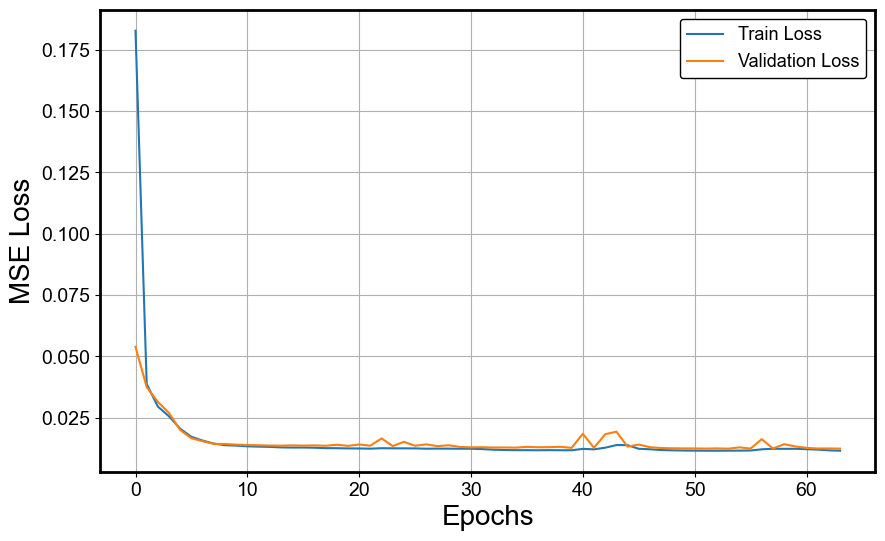

In [43]:
plot_learning_curve(best_model_history)

# Comparing results

In [44]:
df2,_,_ = make_timeseries_instances(df_aux2,window_size=study.best_params['window_size'])

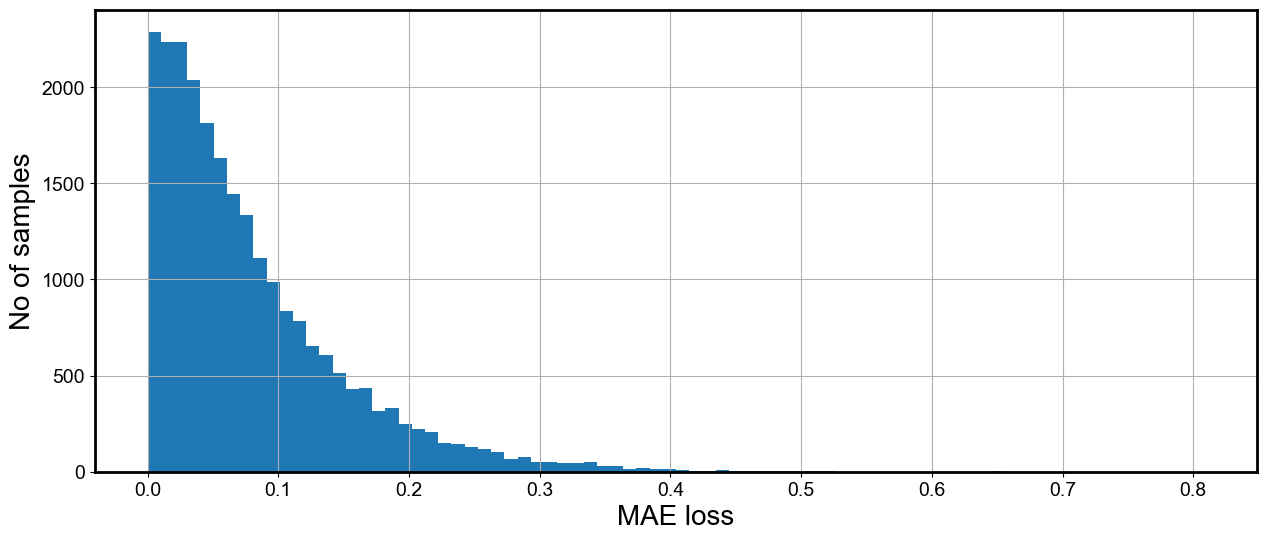

In [45]:
# Reshaping as if the dataset was one giant vector
df_pred = reconstructed_model.predict(df2)
df_pred = df_pred.reshape(-1, 1)

df_flattened = df2.reshape(-1, 1)
mae_loss = np.mean(np.abs(df_pred - df_flattened), axis=1)

plt.hist(mae_loss, bins=80)
plt.xlabel("MAE loss")
plt.ylabel("No of samples")
plt.show()


In [54]:
logic_vector = pd.Series(mae_loss > 0.5)
logic_vector = logic_vector*1 # Converting from boolean to 0,1
logic_vector.name = 'logic'
# logic_vector

In [55]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

Plotting all time series as if it was 1 vector

In [56]:
df_sol = pd.concat([pd.Series(df_pred.flatten()).rename('Prediction'),
           pd.Series(df_flattened.flatten()).rename('Reference'),
           logic_vector], axis=1)

df_sol.iplot()

<AxesSubplot:xlabel='Prediction', ylabel='Reference'>

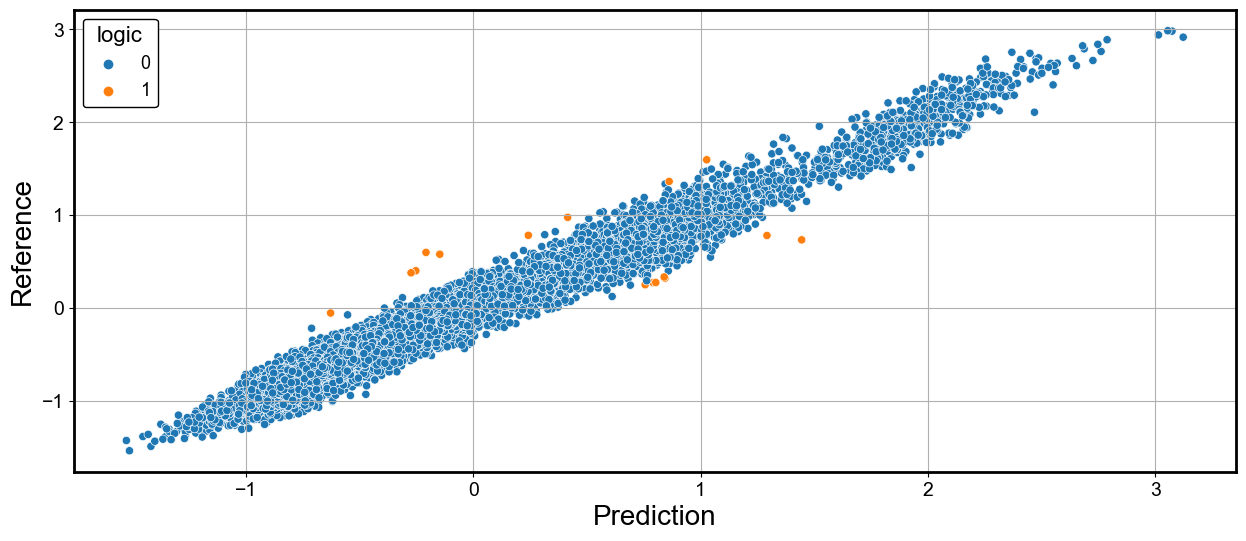

In [57]:
sns.scatterplot(data=df_sol,x='Prediction',y='Reference',hue='logic')

<AxesSubplot:ylabel='Reference'>

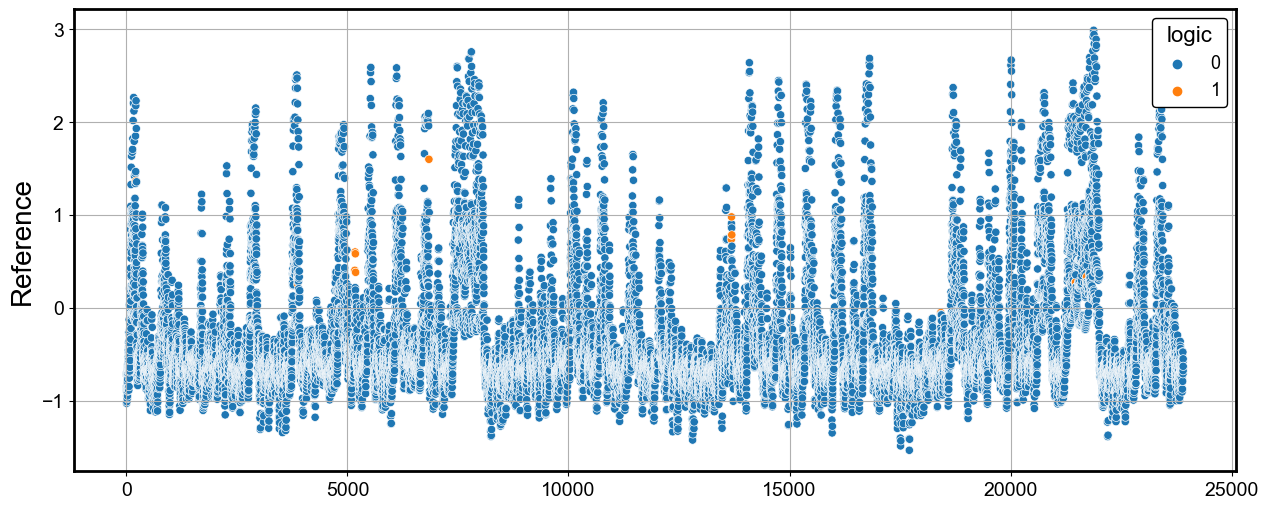

In [58]:
sns.scatterplot(data=df_sol,x=df_sol.index,y='Reference',hue='logic')

Plotting individual time series

In [59]:
pd.concat([pd.Series(df_pred[:,0]).rename('Prediction'),
           pd.Series(df_flattened[:,0]).rename('Reference')], axis=1).iplot()

# Visualizing latent space

In [60]:
encoder = tf.keras.models.load_model("AE_Encoder_1D")

latent_space = encoder(df2)
latent_space

<tf.Tensor: shape=(996, 2), dtype=float32, numpy=
array([[1.7970997 , 0.5361167 ],
       [1.4599303 , 0.26815933],
       [1.048741  , 0.12040949],
       ...,
       [1.1101801 , 0.5777935 ],
       [1.5809835 , 0.46335715],
       [1.3018601 , 0.38662165]], dtype=float32)>

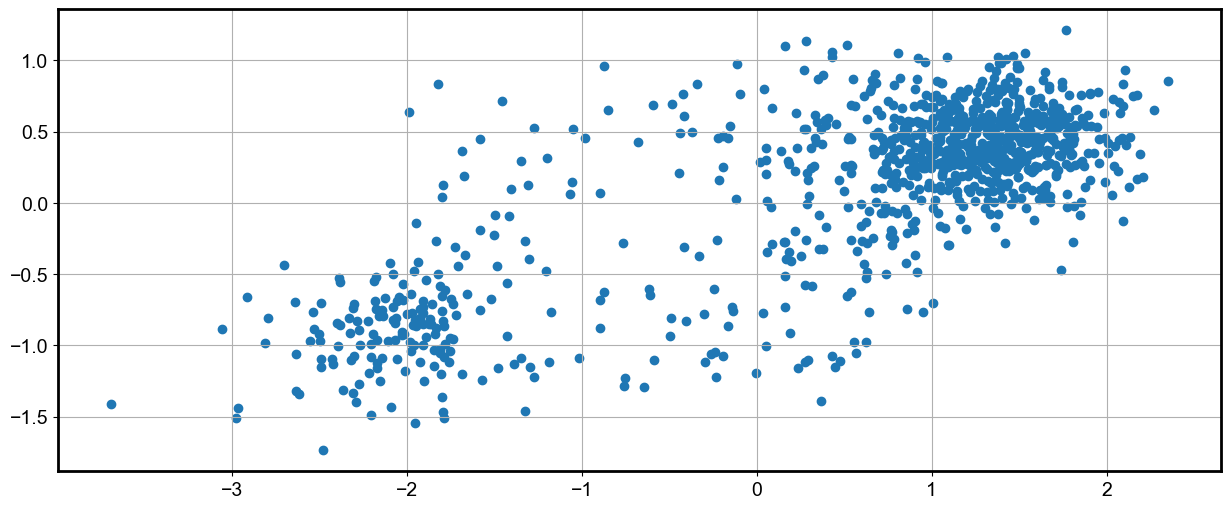

In [61]:
plt.scatter(latent_space[:,0],latent_space[:,1])